# MATH&ML-12. Временные ряды. Часть I

## 3. Тренд, сезонность, шум. Инструменты для декомпозиции временного ряда

Разделить ряд на компоненты в Python можно с помощью библиотеки `statsmodels`. Если вы не устанавливали её ранее, это можно сделать стандартным способом (`pip install statsmodels`) или следуя рекомендациям в официальной документации.

В этом датасете представлены данные о количестве авиапассажиров в 1949-1960 годах. Рассмотрим некоторый временной ряд `df` из данного датасета.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
df = pd.read_csv('data/AirPassengers.zip', index_col='Month', parse_dates=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

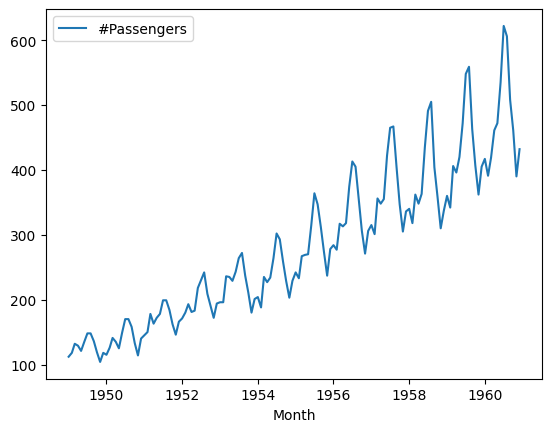

In [14]:
sns.lineplot(df)

Теперь рассмотрим код, в котором демонстрируется, как применять декомпозицию к временному ряду `df`.

Декомпозиция выполняется методом `seasonal_decompose()`, который принимает на вход временной ряд с одним признаком. Индексом ряда должна быть дата или время. Именно поэтому, считывая датасет, мы указываем индексом столбец month и приводим его к формату даты. Также, если вы знаете, что в вашем временном ряду присутствует период, его вы также можете передать в качестве параметра в `seasonal_decompose()`. Более подробно о необязательных параметрах можно узнать в документации.

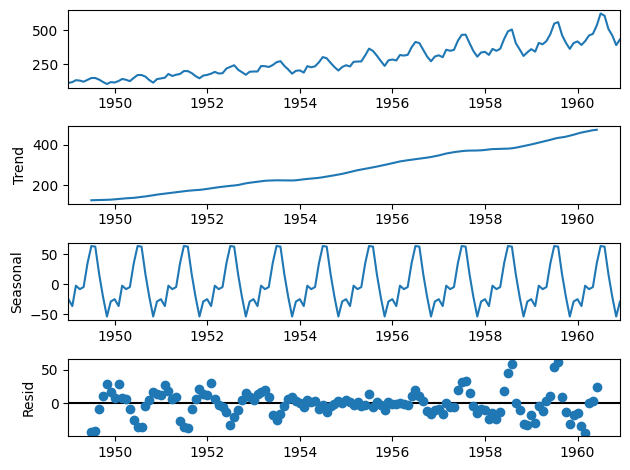

In [21]:
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

## 4. Экспоненциальное сглаживание

Экспоненциальное сглаживание — это метод прогнозирования временных рядов для одномерных данных с трендом или сезонным компонентом. Оно также известно как метод простого экспоненциального сглаживания, или метод Брауна.

Рассмотрим пример.

Нам известны значения температуры за прошедший месяц, и мы хотим предсказать погоду на следующий день. Мы можем предположить, что в этом случае погода завтра в большей степени будет зависеть от погоды вчера и сегодня, чем от погоды 30 дней назад. Если мы хотим учитывать удалённость значений от текущего момента, то экспоненциальное сглаживание пригодится тут как нельзя кстати.

Проще говоря, под экспоненциальным сглаживанием понимается взвешенная линейная сумма наблюдений, при этом веса для наблюдений экспоненциально уменьшаются для более старых наблюдений. Тем самым мы не обращаем особого внимания на поведение в прошлом, а недавнему поведению присваиваем больший вес. Если быть точнее, наблюдения взвешиваются с геометрически уменьшающимся коэффициентом.

[15.      18.5     23.05    27.915   25.8745  26.66235  0.     ]


<Axes: >

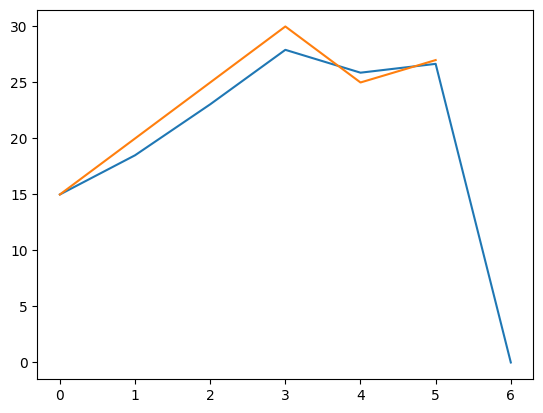

In [29]:
def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(7)
s[0] = data[0]

for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])

print(s)
sns.lineplot(s)
sns.lineplot(data)

В примере выше сглаженный ряд мы рассчитывали «вручную» по формуле, но делать это каждый раз нет необходимости, так как эта возможность уже встроена в библиотеку `statsmodels`. Для совершения предсказания методом простого экспоненциального сглаживания воспользуемся методом `SimpleExpSmoothing` из `statsmodels.tsa.api`.

Попробуйте запустить код ниже:

In [30]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
forecast = model.forecast(1)

print(forecast)

[26.66235]


## 5. Стационарность

Стационарность означает, что сам временной ряд может меняться с течением времени, однако статистические свойства генерирующего его процесса не меняются.

Говоря простым языком, стационарный процесс (стационарный временной ряд) — это процесс, который не меняет свои основные характеристики со временем (обратите внимание на графики стационарного и нестационарного временного ряда выше). Это значит, что при сдвиге во времени не меняются математическое ожидание, дисперсия и совместное распределение вероятности.

Одним из наиболее распространённых тестов на проверку временного ряда на стационарность является расширенный тест Дики — Фуллера. В тесте формулируется две гипотезы:

* нулевая гипотеза (H0): временной ряд нестационарный, то есть имеет некоторый тренд и сезонную компоненту;
* альтернативная гипотеза (H1): временной ряд стационарный, то есть не имеет тренда и сезонной компоненты, и данные скорее случайны.

В результате проведения теста мы получим несколько значений: значение статистики из теста и критические значения разных уровней значимости (1 %, 2 %, 3 %). Уровень значимости означает допустимую  для данной задачи вероятность ошибки, то есть чем ниже уровень значимости, тем ниже вероятность ошибочного результата теста.

* Если значение статистики ниже критического значения выбранного уровня значимости, отвергаем гипотезу H0 и принимаем гипотезу H1 (ряд стационарный).
* Если значение статистики выше критического значения выбранного уровня значимости, принимаем гипотезу H0 (ряд нестационарный).

Рассмотрим пример проведения теста Дики — Фуллера на данных временного ряда Daily Total Female Births. В данных содержится количественная информация о девочках, рождённых за несколько месяцев. Для проведения теста будем использовать функцию `adfuller()` из пакета `statsmodels`.

In [32]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(
	"data/daily-total-female-births.zip", 
    header=0, 
    index_col=0
).squeeze("columns")

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: -4.808291253559767
p-value: 5.243412990149787e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


<Axes: xlabel='Date', ylabel='Births'>

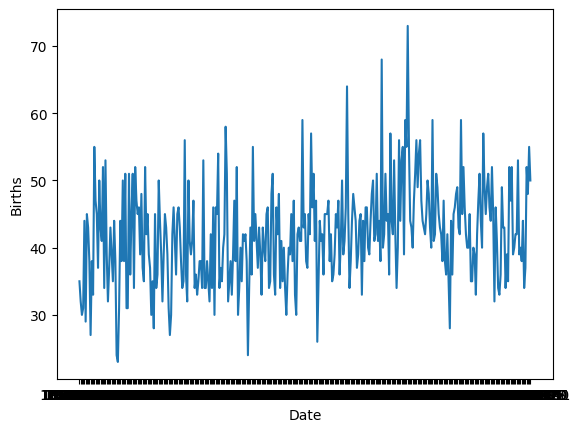

In [33]:
sns.lineplot(df)

#### ЧТО ДЕЛАТЬ, ЕСЛИ РЯД НЕСТАЦИОНАРНЫЙ?

Если тест на стационарность показал, что ряд нестационарный и в нём присутствуют тренд и сезонность, необходимо избавиться от них.

Обычно для этого достаточно взять разность рядов. Разность выполняется путём дифференцирования ряда, для этого вычисляется разность между двумя соседними наблюдениями ряда. Если полученная первая разность ряда окажется стационарной, то этот ряд называется интегрированным рядом первого порядка.

Для определения порядка интегрированного ряда необходимо сделать следующее:

Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):

<Axes: xlabel='Date', ylabel='Births'>

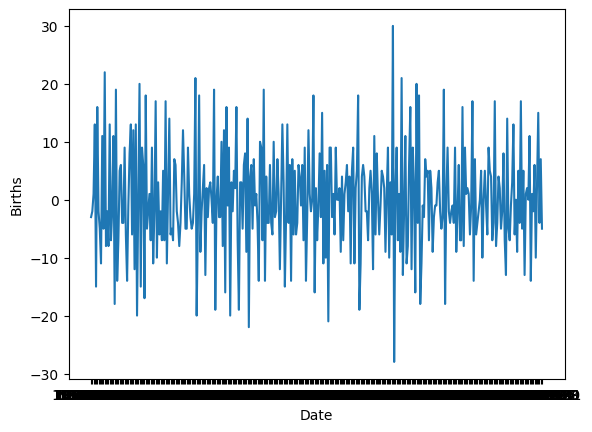

In [36]:
df_diff_1 = df.diff().dropna()
sns.lineplot(df_diff_1)

Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):

In [37]:
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -12.625178633871338
p-value:  1.5472400091970336e-23
Critical values:  {'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}
ряд стационарен


## 7. Авторегрессия

Авторегрессионная модель — это модель временных рядов, которая описывает, как прошлые значения временного ряда влияют на его текущее значение. Как можно понять из значений частей слова, авторегрессия представляет собой линейную регрессию на себя.

В контексте прогнозирования временных рядов авторегрессионное моделирование будет означать создание модели, в которой переменная Y будет зависеть от предыдущих значений Y с заранее определённой постоянной задержкой во времени. Временной лаг может быть ежедневным (или два, три, четыре дня и т. д.), еженедельным, ежемесячным и т. п.

Модель, в которой для расчёта следующего значения используется только предыдущее, называется моделью первого порядка, или AR(1).

 Обобщённая формула для AR-модели с параметром p будет выглядеть следующим образом:

Y<small style="text-transform: lowercase;">t</small> = &beta;<small style="text-transform: lowercase;">0</small> + &beta;<small style="text-transform: lowercase;">1</small> &times; Y<small style="text-transform: lowercase;">t-1</small> + ... + &beta;<small style="text-transform: lowercase;">p</small> &times; Y<small style="text-transform: lowercase;">t-p</small> + error<small style="text-transform: lowercase;">t</small> 

Одним из основных методов оценивания вектора неизвестных параметров  является метод наименьших квадратов (МНК). Если ошибки модели имеют нормальное распределение, то данный метод также эквивалентен условному методу максимального правдоподобия. Так как коэффициенты настраиваются в процессе обучения модели, вам необходимо лишь верно определить параметр модели p.


### КАК ВЫБИРАТЬ P?

В предыдущем юните мы познакомились с автокорреляцией и частичной автокорреляцией. Для определения значения p будем использовать график частичной автокорреляции — будем обращать внимание на последний лаг, сильно отличный от нуля, при условии, что ряд стационарный.

### AR-МОДЕЛИРОВАНИЕ НА PYTHON

Для загрузки класса `ar_model.AutoReg`, который применяется для обучения одномерной авторегрессионной модели порядка `p`, используется пакет `statsmodels.tsa`.

Ниже приведены некоторые из ключевых шагов, которые необходимо выполнить для обучения AR-модели:

1. Отобразить временной ряд.
2. Проверить ряд на стационарность (модель AR можно применять только к стационарному временному ряду).
3. Выбрать параметр p (порядок модели AR).
4. Обучить модель.

Все эти шаги вы будете выполнять в итоговой практике, а пока давайте перейдём к самому инструменту моделирования.

Применим авторегрессионную модель к датасету по производству возобновляемой энергии в Германии. Набор данных включает общую информацию о потреблении электроэнергии в стране, а также о производстве ветровой и солнечной энергии за 2006–2017 годы.

Признаки в данных:

* `Date` — дата (в формате гггг-мм-дд);
* `Consumption` — потребление электроэнергии (ГВтч);
* `Wind` — производство ветровой энергии (ГВтч);
* `Solar` — производство солнечной энергии (ГВтч);
* `Wind+Solar` — сумма производства ветровой и солнечной энергии (ГВтч).

В качестве примера построим предсказание объёма потребления электроэнергии на три месяца (возьмём последние 100 дней).

Импортируем необходимые библиотеки и загрузим датасет с данными.